# Converting Microscopy Images with a CycleGAN

This notebook provides you with a complete code example to convert between holographic and brightfield images using a CycleGAN.

## Downloading and Preparing the Holo2Bright Dataset

The Holo2Bright dataset consists of holographic and brightfield microscopy images of marine microplankton. The dataset consists of 4500 holographic images and 880 brightfield images for training, and 4500 holographic images and 244 brightfield images for testing. The size of all images is 256 by 256 pixels.

Download the Holo2Bright dataset ...

In [15]:
import os

if not os.path.exists("holo2bright_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/holo2bright_dataset")

... implement a Dataset object to manage the images ...

In [16]:
import numpy as np
import torch
from PIL import Image

class Holo2BrightDataset(torch.utils.data.Dataset):
    """Dataset conatining the Holo2Bright dataset."""

    def __init__(self, directory, transform=None):
        """Initialize dataset."""
        self.transform = transform
        
        self.holo_dir = os.path.join(directory, "holography")
        self.holo_images = os.listdir(self.holo_dir)

        self.bright_dir = os.path.join(directory, "brightfield")
        self.bright_images = os.listdir(self.bright_dir)

    def __len__(self):
        """Return number of images."""
        return min(len(self.bright_images), len(self.holo_images))

    def __getitem__(self, index):
        """Get holographic and brightfield images."""
        holo_index = np.random.randint(len(self.holo_images))
        holo_image = Image.open(
            os.path.join(self.holo_dir, self.holo_images[holo_index])
        )

        bright_index = np.random.randint(len(self.bright_images))
        bright_image = Image.open(
            os.path.join(self.bright_dir, self.bright_images[bright_index])
        )
        
        if self.transform:
            seed = np.random.randint(1_000_000_000)

            torch.manual_seed(seed)
            holo_image = self.transform[0](holo_image)

            torch.manual_seed(seed)
            bright_image = self.transform[1](bright_image)

        return holo_image, bright_image

... implement the necessary augmentations, transformations, and normalizations ...

In [17]:
from torchvision import transforms as trans

trans_holo = trans.Compose([
    trans.RandomHorizontalFlip(p=0.5), trans.RandomVerticalFlip(p=0.5), 
    trans.ToTensor(), trans.Normalize(mean=[0.5], std=[0.5]),
])
trans_bright = trans.Compose([
    trans.RandomHorizontalFlip(p=0.5), trans.RandomVerticalFlip(p=0.5), 
    trans.ToTensor(), trans.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])

... create the training and testing datasets ...

In [18]:
train_dataset = Holo2BrightDataset(
    directory=os.path.join("holo2bright_dataset", "holo2bright", "train"),
    transform=[trans_holo, trans_bright],
)
test_dataset = Holo2BrightDataset(
    directory=os.path.join("holo2bright_dataset", "holo2bright", "train"),
    transform=[trans_holo, trans_bright],
)

... and plot some holographic and brightfield images.

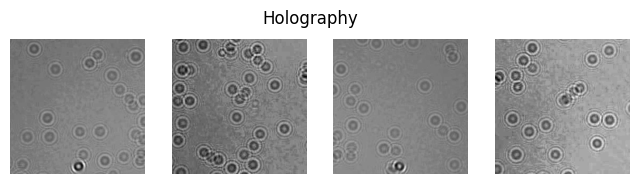

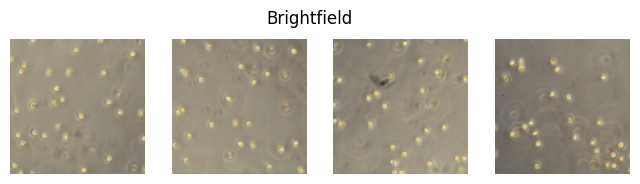

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    ax[i].imshow(train_dataset[i][0][0], cmap="gray")
    ax[i].axis("off")
fig.suptitle("Holography")
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    img = train_dataset[i][1].permute(1, 2, 0).numpy()
    img = (((img * 0.5) + 0.5) * 255.0).astype(np.uint8)
    ax[i].imshow(img)
    ax[i].axis("off")
fig.suptitle("Brightfield")
plt.show()

## Instantiating the CycleGAN Generators and Discriminators

Determine the device to be used in the computations ...

In [20]:
def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

... define the generators ...

In [21]:
import deeplay as dl

gen_H2B = dl.CycleGANResnetGenerator(in_channels=1, out_channels=3).build()
gen_B2H = dl.CycleGANResnetGenerator(in_channels=3, out_channels=1).build()
gen_H2B.to(device), gen_B2H.to(device);


... define the discriminators ...

In [22]:
disc_H = dl.CycleGANDiscriminator(in_channels=1).build()
disc_B = dl.CycleGANDiscriminator(in_channels=3).build()
disc_H.to(device), disc_B.to(device);

... define the losses ...

In [23]:
loss_gen = torch.nn.L1Loss()
loss_disc = torch.nn.MSELoss()

... define the optimizers ...

In [24]:
optim_gen = torch.optim.Adam(
    list(gen_H2B.parameters()) + list(gen_B2H.parameters()), 
    lr=0.0002, betas=(0.5, 0.999),
)
optim_disc = torch.optim.Adam(
    list(disc_H.parameters()) + list(disc_B.parameters()), 
    lr=0.0002, betas=(0.5, 0.999),
)

... and define the data loaders.

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                          shuffle=False)

## Training the CycleGAN

Implement a function to train the CycleGAN ...

In [26]:
def train_model(input_image_H, input_image_B, optim_disc, optim_gen, 
                L1_Lambda_H, L1_Lambda_B):
    """Train CycleGAN for one epoch."""
    # 1. Training discriminators.
    optim_disc.zero_grad()

    # Train discriminator B (as a part of the transformation H -> B).
    fake_image_B = gen_H2B(input_image_H)
    disc_B_fake = disc_B(fake_image_B.detach())
    disc_B_real = disc_B(input_image_B)

    # Compute discriminator B losses.
    disc_B_loss_real = loss_disc(disc_B_real, torch.ones_like(disc_B_real))
    disc_B_loss_fake = loss_disc(disc_B_fake, torch.zeros_like(disc_B_fake))
    disc_B_loss = disc_B_loss_real + disc_B_loss_fake

    # Train discriminator H (as a part of the transformation B -> H).
    fake_image_H = gen_B2H(input_image_B)
    disc_H_real = disc_H(input_image_H)
    disc_H_fake = disc_H(fake_image_H.detach())

    # Compute discriminator H losses.
    disc_H_loss_real = loss_disc(disc_H_real, torch.ones_like(disc_H_real))
    disc_H_loss_fake = loss_disc(disc_H_fake, torch.zeros_like(disc_H_fake))
    disc_H_loss = disc_H_loss_real + disc_H_loss_fake

    # Total discriminator loss, backpropagation, and weight update.
    disc_loss = (disc_B_loss + disc_H_loss) / 2
    disc_loss.backward()
    optim_disc.step()

    # 2. Training generators.
    optim_gen.zero_grad()
    
    # Train generators.
    disc_B_fake = disc_B(fake_image_B)
    disc_H_fake = disc_H(fake_image_H)

    # Adversarial loss (from generators perspective).
    gen_H2B_loss = loss_disc(disc_B_fake, torch.ones_like(disc_B_fake))
    gen_B2H_loss = loss_disc(disc_H_fake, torch.ones_like(disc_H_fake))

    # 3. Cycle consistency loss
    cycle_H = gen_B2H(fake_image_B)
    cycle_B = gen_H2B(fake_image_H)
    cycle_H_loss = loss_gen(input_image_H, cycle_H)
    cycle_B_loss = loss_gen(input_image_B, cycle_B)

    # Total generator loss, backpropagation, and weight update.
    gen_loss = (gen_H2B_loss + gen_B2H_loss 
                + L1_Lambda_H * cycle_H_loss + L1_Lambda_B * cycle_B_loss)
    gen_loss.backward()
    optim_gen.step()

    return disc_loss, gen_loss

... implement a function to evaluate the CycleGAN ...

In [27]:
def evaluate_model(image_H, image_B):
    """Evaluate CycleGAN in each epoch."""
    # Generate fake images 
    gen_H2B.eval(), gen_B2H.eval()
    fake_image_B, fake_image_H = gen_H2B(image_H), gen_B2H(image_B)
    gen_H2B.train(), gen_B2H.train()
    
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    axs = axs.flatten()

    img_H_in = image_H[0].permute(1, 2, 0).cpu().detach().numpy()
    axs[0].imshow(img_H_in, cmap="gray")
    axs[0].set_title("Input: Holography", fontsize=8)
    axs[0].axis("off")

    img_B_in = image_B[0].permute(1, 2, 0).cpu().detach().numpy()
    img_B_in = (((img_B_in * 0.5) + 0.5) * 255.0).astype(np.uint8)
    axs[1].imshow(img_B_in)
    axs[1].set_title("Input: Brightfield", fontsize=8)
    axs[1].axis("off")

    img_B_out = fake_image_B[0].permute(1, 2, 0).cpu().detach().numpy()
    img_B_out = (((img_B_out * 0.5) + 0.5) * 255.0).astype(np.uint8)
    axs[2].imshow(img_B_out)
    axs[2].set_title("Output: Brightfield", fontsize=8)
    axs[2].axis("off")

    img_H_out = fake_image_H[0].permute(1, 2, 0).cpu().detach().numpy()
    axs[3].imshow(img_H_out, cmap="gray")
    axs[3].set_title("Output: Holography", fontsize=8)
    axs[3].axis("off")

    plt.show()
    plt.close(fig)

... and define the trainign cycle.

In [28]:
import time
from datetime import timedelta

epochs = 100

gen_loss_epochs, disc_loss_epochs = [], []
for epoch in range(epochs):
    start_time = time.time()

    n_batches = len(train_loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)

    gen_loss_batches, disc_loss_batches = [], []
    for i, (inputs_H, inputs_B) in enumerate(train_loader, 0):
        inputs_H, inputs_B = inputs_H.to(device), inputs_B.to(device)
        disc_loss, gen_loss = train_model(input_image_H=inputs_H, \
            input_image_B=inputs_B, optim_disc=optim_disc, \
            optim_gen=optim_gen, L1_Lambda_H=10, L1_Lambda_B=5)
        
        if i % 20 == 0:
            print(f"Batch {i + 1}/{n_batches} : "
                  + f"Generator Loss: {gen_loss.item():.4f}, "
                  + f"Discriminator Loss: {disc_loss.item():.4f}")

        gen_loss_batches.append(gen_loss.item())
        disc_loss_batches.append(disc_loss.item())

    end_time = time.time()

    print("-" * 10 + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Generator Loss: {np.mean(gen_loss_batches):.4f}, "
          + f"Discriminator Loss: {np.mean(disc_loss_batches):.4f}"
          + "\n" + f"Time taken: {timedelta(seconds=end_time - start_time)}")
        
    for test_inputs_H, test_inputs_B in test_loader:
        test_inputs_H = test_inputs_H.to(device)
        test_inputs_B = test_inputs_B.to(device)
        break
    evaluate_model(test_inputs_H.to(device), test_inputs_B.to(device))
    gen_loss_epochs.append(np.mean(gen_loss_batches))
    disc_loss_epochs.append(np.mean(disc_loss_batches))


Epoch 1/100
----------
Batch 1/110 : Generator Loss: 7.1239, Discriminator Loss: 0.5189
Batch 21/110 : Generator Loss: 2.4316, Discriminator Loss: 0.2237
Batch 41/110 : Generator Loss: 2.6941, Discriminator Loss: 0.0907
Batch 61/110 : Generator Loss: 2.6464, Discriminator Loss: 0.0349
Batch 81/110 : Generator Loss: 2.6403, Discriminator Loss: 0.1108
Batch 101/110 : Generator Loss: 2.6414, Discriminator Loss: 0.0196
----------Epoch 1/100 : Generator Loss: 2.6004, Discriminator Loss: 0.1254
Time taken: 0:06:29.655432

Epoch 2/100
----------
Batch 1/110 : Generator Loss: 2.5769, Discriminator Loss: 0.0125
Batch 21/110 : Generator Loss: 2.7428, Discriminator Loss: 0.0044
Batch 41/110 : Generator Loss: 2.8182, Discriminator Loss: 0.0144
Batch 61/110 : Generator Loss: 2.7953, Discriminator Loss: 0.0045
Batch 81/110 : Generator Loss: 2.6264, Discriminator Loss: 0.0032
Batch 101/110 : Generator Loss: 2.5049, Discriminator Loss: 0.0025
----------Epoch 2/100 : Generator Loss: 2.7781, Discrimina